# Capturing Key Variance with PCA

To reduce noise and simplify clustering, we apply Principal Component Analysis (PCA). This step compresses the dataset while preserving most of the variance. We select the number of components needed to retain ~90% of the variance.

# Environmnet & Data

Prepares the notebook voor dimensionality reduction with PCA.

In [2]:
# Importss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization Setting
sns.set(style="whitegrid", context="notebook")

# Load raw data
RAW_CSV = "../data/processed/final_master.csv"
df_raw = pd.read_csv(RAW_CSV)

df_features = df_raw.drop(columns=["ortsteil", "bezirk", "subdistrict_avg_mietspiegel_classification", "classification_category"])

# Load PCA reduced data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_scaled.fillna(0, inplace=True)

PCA_CSV = "../data/modeling/berlin_pca/berlin_subdistricts_pca.csv"
df_pca = pd.read_csv(PCA_CSV)

id_col = "ortsteil"
pc_cols = [c for c in df_pca.columns if c.startswith("PC")]

In [3]:
# Data overview
print("Shape:", df_pca.shape, "| PCs:", len(pc_cols))
df_pca.head(2)

Shape: (96, 24) | PCs: 23


,ortsteil,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,adlershof,-2.848294,1.221917,0.930650,-0.776905,0.344805,-0.368626,0.179747,1.088751,-0.171862,...,2.565602,-2.733888,1.594062,2.024621,4.689300,-3.545404,1.838757,1.418893,1.923239,-0.373466
1,alt-hohenschoenhausen,1.381981,-1.169254,-1.391295,0.141142,0.135140,0.214386,-0.919337,-0.072401,-0.809384,...,-0.090372,-0.154496,0.204430,0.090303,0.191817,-0.362755,-0.395248,-0.266762,-0.115360,0.033706


# Explore Principal Components

Before clustering, we first visualize the dataset in principal component space. PCA reduces the many socioeconomic and amenity variables into a few components that capture the largest share of variance. 

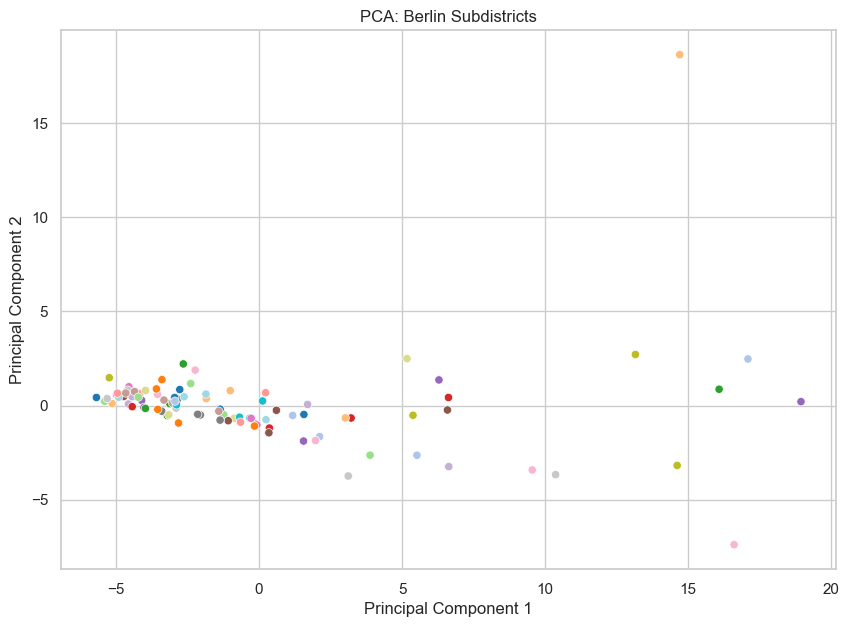

In [8]:
# Keep 2 components to visualize
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(df_scaled)

# Turn into DataFrame
df_pca = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"])
df_pca["ortsteil"] = df_raw["ortsteil"].values  # Add back labels for tracking

# Visualize PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="ortsteil", palette="tab20", legend=False)
plt.title("PCA: Berlin Subdistricts")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

🔖 **Key Insights**

* Most subdistricts cluster near the center, indicating shared “average” profiles.

* A handful of subdistricts spread out along the PC1 axis, reflecting major differences in income, rent, and amenities.

* A few points are clear outliers, representing unique neighborhoods with distinct socioeconomic or amenity patterns.

# Reducing Dimensionality

To decide how many principal components (PCs) to retain, we examine the cumulative variance explained by PCA. Each PC captures a portion of the dataset’s variation; by summing them, we see how much of the original information is preserved as we reduce dimensionality.

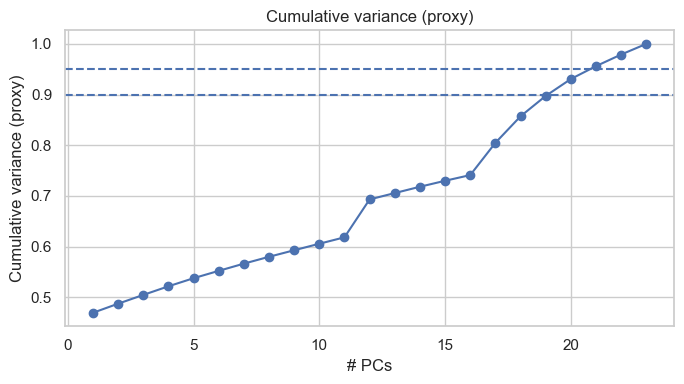

In [ ]:
# Scree plot
var = df_pca[pc_cols].var().sort_index()
cum = var.cumsum() / var.sum()

plt.figure(figsize=(7,4))
plt.plot(range(1, len(pc_cols)+1), cum.values, marker="o")
plt.axhline(0.90, ls="--")
plt.axhline(0.95, ls="--")
plt.xlabel("# PCs"); plt.ylabel("Cumulative variance (proxy)")
plt.title("Cumulative variance (proxy)"); plt.tight_layout(); plt.show()

🔖 **Key Insights**

* The curve rises steadily as more components are added, meaning each new PC contributes incremental information.

* Around 20 PCs, the cumulative variance passes the 90% threshold (shown by the dashed line). This means that 20 components retain most of the original dataset’s variability while removing noise and redundancy.

* Beyond 20 PCs, the curve flattens, suggesting diminishing returns from adding more components.

* Selecting ~20 PCs strikes a balance: enough dimensions to capture meaningful variation, but reduced complexity for clustering.

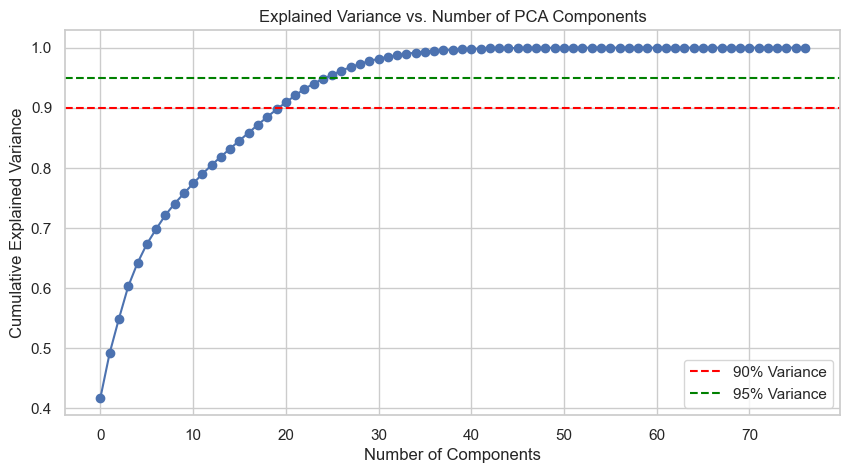

In [7]:
pca_full = PCA().fit(df_scaled)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
plt.axhline(0.9, color='red', linestyle='--', label='90% Variance')
plt.axhline(0.95, color='green', linestyle='--', label='95% Variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of PCA Components")
plt.legend()
plt.grid(True)
plt.show()

🔖 **Key Insights**

* The cumulative variance curve shows that ~20–25 principal components are enough to explain 90–95% of the variance in the dataset.

* Beyond this, the curve flattens, meaning additional components provide little extra information.